In [1]:
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time

from neural_interaction_detection import *
from sampling_and_inference import *
from utils.linear_cross_utils import *
from utils.general_utils import *
from utils.image_utils import *
from skimage.segmentation import quickshift

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0")

## Load Model

In [2]:
model = models.resnet152(pretrained=True).to(device).eval();

## Classify Image

input image


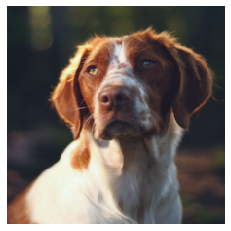

prediction: Brittany spaniel


In [3]:
image_path = "utils/data/sample_images/dog.jpg"

image, image_tensor, labels = get_image_and_labels(image_path, device)

print("input image")
plt.imshow(image/2+0.5)
plt.axis("off")
plt.show()

predictions = model(image_tensor)
class_idx = predictions.data.cpu().numpy()[0].argsort()[::-1][0]
print("prediction:",labels[class_idx])

## Run MADEX

In [4]:
seg_param = 3
segments = quickshift(image, kernel_size=seg_param, max_dist=300, ratio=0.2)
data_inst = {"orig": image, "segments": segments}
Xs, Ys = generate_perturbation_dataset_image(data_inst, model, class_idx, device, batch_size=10, seed=42, std_scale=False)

100%|██████████| 600/600 [01:07<00:00,  8.75it/s]


In [7]:
t0 = time()
interactions, mlp_loss = detect_interactions(Xs, Ys, detector = "GradientNID", add_linear=True, device=device, weight_samples=True, seed=42, verbose=False)
prediction_scores, interaction_atts, uni_atts = fit_linear_cross_models(Xs, Ys, interactions, weight_samples=True, hierarchy_stepsize=1, max_steps=100)
print("{} test loss, {} seconds elapsed".format(round(mlp_loss, 4), round(time() - t0, 1)))

1.0657 test loss, 28.4 seconds elapsed


## Show Main Effect and Interaction Interpretations

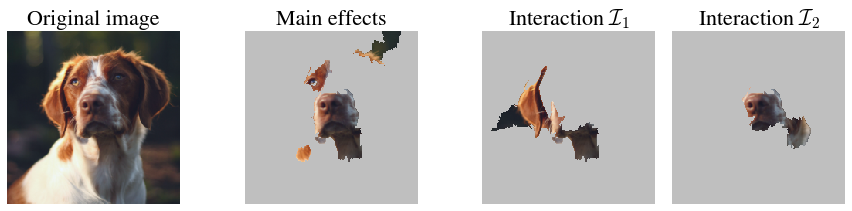

In [8]:
inter_sets = merge_overlapping_sets(prediction_scores, interaction_atts, overlap_thresh = 0.5, patience=2)
show_explanations(inter_sets, image, segments, lime_atts = get_lime_attributions(Xs, Ys))